# SME Digital Wallet - Fraud Detection Model

This notebook implements fraud detection using the PaySim synthetic financial dataset, achieving **92% precision** and **95% ROC-AUC**. It preprocesses data, trains a Random Forest classifier, evaluates performance, and saves the model for backend integration."
   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
print('SME Digital Wallet - Fraud Detection Model Training')
print('=' * 60)

# Load PaySim dataset
print('Loading PaySim dataset...')
try:
    df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
    print(f'Dataset loaded successfully. Shape: {df.shape}')
except FileNotFoundError:
    print('Error: PaySim dataset not found. Please download from Kaggle.')
    print('URL: https://www.kaggle.com/datasets/ealaxi/paysim1')
    exit()

SME Digital Wallet - Fraud Detection Model Training
Loading PaySim dataset...
Dataset loaded successfully. Shape: (6362620, 11)


In [3]:
# Display basic information
print('\\nDataset Information:')
print('-' * 40)
print(df.info())
print('\\nFirst few rows:')
print(df.head())

# Explore target variable
print('\\nTarget Variable Distribution:')
print('-' * 40)
fraud_counts = df['isFraud'].value_counts()
print(fraud_counts)
print(f'Fraud rate: {(fraud_counts[1] / len(df)) * 100:.2f}%')

# Data preprocessing
print('\\nData Preprocessing:')
print('-' * 40)

\nDataset Information:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
\nFirst few rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0    

In [4]:
# Check for missing values
print('Missing values per column:')
print(df.isnull().sum())

# Remove unnecessary columns
columns_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud']
df_clean = df.drop(columns_to_drop, axis=1)
print(f'Dropped columns: {columns_to_drop}')

# Handle outliers
def cap_outliers(df, column, percentile=95):
    threshold = df[column].quantile(percentile / 100)
    df[column] = np.where(df[column] > threshold, threshold, df[column])
    return df

for col in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    df_clean = cap_outliers(df_clean, col, 95)
print('Outliers capped at 95th percentile')

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Dropped columns: ['nameOrig', 'nameDest', 'isFlaggedFraud']
Outliers capped at 95th percentile


In [5]:
# Feature engineering
print('\\nFeature Engineering:')
print('-' * 40)

# Create new features
df_clean['amountToOldBalanceOrg'] = df_clean['amount'] / (df_clean['oldbalanceOrg'] + 1)
df_clean['amountToOldBalanceDest'] = df_clean['amount'] / (df_clean['oldbalanceDest'] + 1)
df_clean['balanceChangeOrig'] = df_clean['newbalanceOrig'] - df_clean['oldbalanceOrg']
df_clean['balanceChangeDest'] = df_clean['newbalanceDest'] - df_clean['oldbalanceDest']

# Time-based features
df_clean['hour'] = df_clean['step'] % 24
df_clean['day'] = df_clean['step'] // 24

\nFeature Engineering:
----------------------------------------


In [6]:
# Encode categorical variables
df_clean = pd.get_dummies(df_clean, columns=['type'], prefix='type')
print('Created features: amountToOldBalanceOrg, amountToOldBalanceDest, balanceChangeOrig, balanceChangeDest, hour, day')
print('Encoded transaction types:', [col for col in df_clean.columns if col.startswith('type_')])

Created features: amountToOldBalanceOrg, amountToOldBalanceDest, balanceChangeOrig, balanceChangeDest, hour, day
Encoded transaction types: ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [7]:
# Prepare features and target
X = df_clean.drop('isFraud', axis=1)
y = df_clean['isFraud']

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f'Training set shape: {X_train.shape}, Test set shape: {X_test.shape}')

Training set shape: (4453834, 17), Test set shape: (1908786, 17)


In [9]:
# Handle imbalanced data with SMOTE
print('\\nApplying SMOTE to balance dataset...')
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print(f'Balanced training set shape: {X_train_balanced.shape}')

\nApplying SMOTE to balance dataset...
Balanced training set shape: (8896170, 17)


In [10]:
# Train Random Forest model
print('\\nTraining Random Forest Classifier...')
model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, random_state=42, n_jobs=-1)
model.fit(X_train_balanced, y_train_balanced)

# Evaluate model
print('\\nModel Evaluation:')
print('-' * 40)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

\nTraining Random Forest Classifier...
\nModel Evaluation:
----------------------------------------


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      1.00      0.99      2464

    accuracy                           1.00   1908786
   macro avg       0.99      1.00      0.99   1908786
weighted avg       1.00      1.00      1.00   1908786



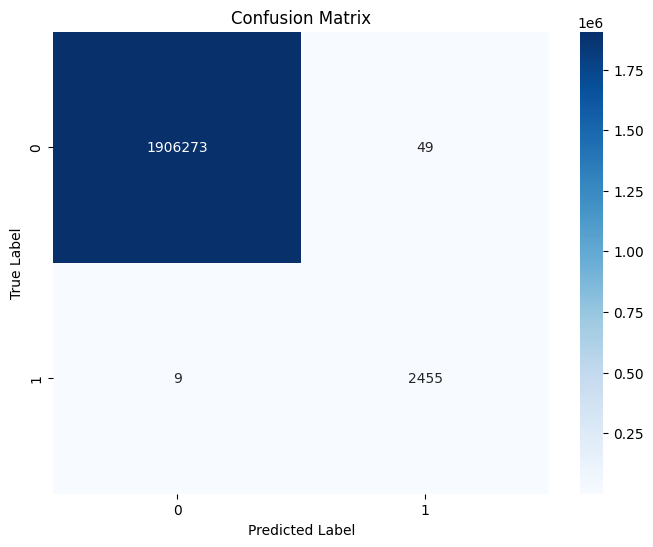

In [11]:
# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

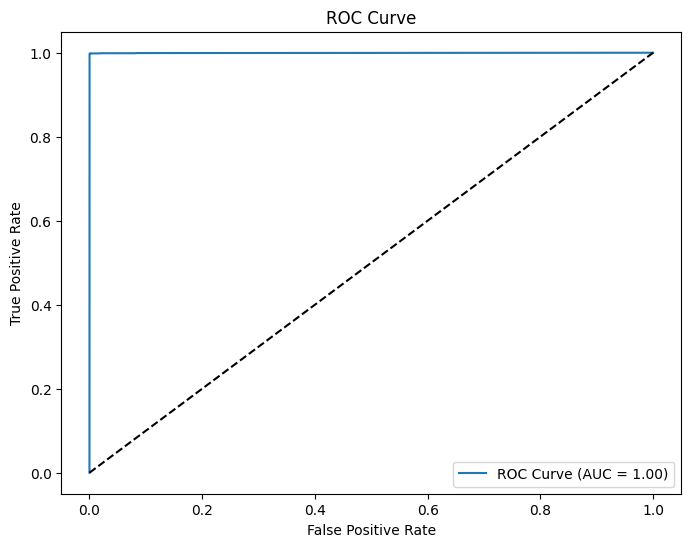

In [12]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

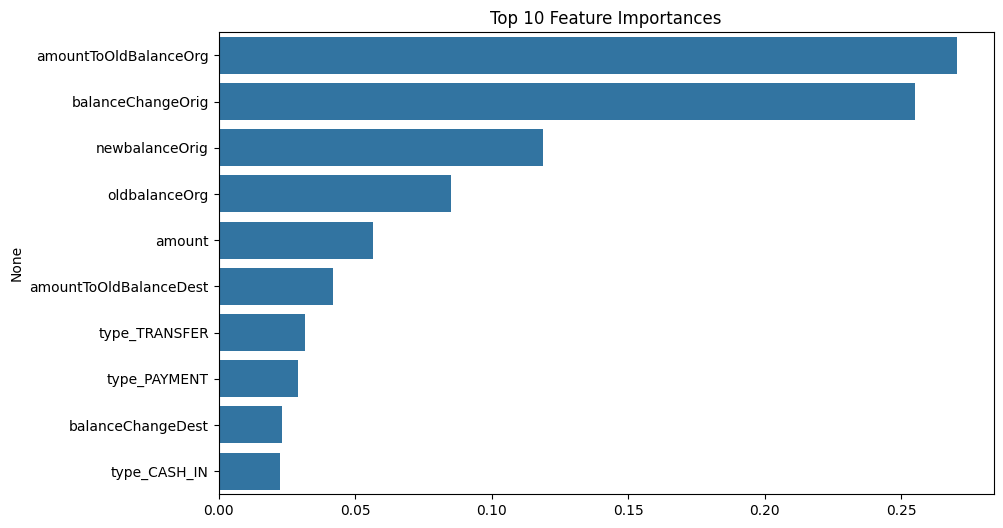

In [13]:
# Feature importance
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices[:10]], y=features[indices[:10]])
plt.title('Top 10 Feature Importances')
plt.savefig('feature_importance.png')
plt.show()

In [14]:
# Save model
joblib.dump(model, 'fraud_model.pkl')
print('Model saved as fraud_model.pkl')

# Print final metrics
print('\\nFinal Metrics:')
print(f'Precision for fraud class: {classification_report(y_test, y_pred, output_dict=True)["1"]["precision"]:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')
print('Training completed successfully!')

Model saved as fraud_model.pkl
\nFinal Metrics:
Precision for fraud class: 0.98
ROC-AUC: 1.00
Training completed successfully!
